# Метрики модели

In [17]:
from sklearn.metrics import classification_report
from src.packages.path_storage import PathStorage
from src.packages.loaders import ModelLoader
from src.packages.loaders import DataLoader
from rich.jupyter import print
import time


def make_text_green_bold(text: str) -> str:
    return "[green bold]" + text + "[/]"


data = DataLoader.load_pandas_dataframe(PathStorage.get_path_to_data() / 'all_patterns_and_its_intents.csv')
train_x = DataLoader.load_numpy_array(PathStorage.get_path_to_data() / 'perceptron' / "train_x_sparse_for_perceptron.npy")
train_y = DataLoader.load_numpy_array(PathStorage.get_path_to_data() / 'perceptron' / "train_y_sparse_for_perceptron.npy")

data = data.rename(columns={'intent': 'true_intent'})
data

pattern      true_intent
0                                                Привет        greetings
1                                           Добрый день        greetings
2                                          Здравствуйте        greetings
3                                          Добрый вечер        greetings
4                                           Доброе утро        greetings
...                                                 ...              ...
2732  Какие технические проблемы решались командой р...  who_created_you
2733  Какие стратегии разработчики применяют для неп...  who_created_you
2734  Какие практики и методологии разработки примен...  who_created_you
2735  Какие идеи и предложения пользователей внедрен...  who_created_you
2736  Какие преимущества имеет команда разработчиков...  who_created_you

[2737 rows x 2 columns]

In [18]:
import tensorflow as tf

unique_sorted_intents = DataLoader.load_numpy_array(PathStorage.get_path_to_data() / "unique_sorted_intents.npy")
to_predict = ModelLoader.load(PathStorage.get_path_to_models() / 'pipelines' / 'perceptron' / 'to_predict.dill')
model = ModelLoader.load(PathStorage.get_path_to_models() / "perceptron" / "perceptron.h5")

to_predict

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('removegarbage', RemoveGarbage()),
                                 ('correctorthography',
                                  CorrectOrthography(lang=['en', 'ru'])),
                                 ('tokenize', Tokenize()),
                                 ('tobaseform', ToBaseForm()),
                                 ('removestopwords', RemoveStopWords())])),
                ('fixtypos', FixTypos()),
                ('totfidfvectorpatterns',
                 ToTFIDFVectorPatterns(is_sparse=True)),
                ('sparsetensortransformer', SparseTensorTransformer())])

In [19]:
from scipy.sparse import vstack

train_x = vstack(train_x)
sparse_tensor_train = tf.sparse.SparseTensor(
    indices=list(zip(*train_x.nonzero())),  # индексы ненулевых элементов
    values=train_x.data,  # значения ненулевых элементов
    dense_shape=train_x.shape  # размерность разреженной матрицы
)
sparse_tensor_train = tf.sparse.reorder(sparse_tensor_train)

sparse_tensor_train

SparseTensor(indices=tf.Tensor(
[[   0  162]
 [   0  180]
 [   0  224]
 ...
 [2734 1626]
 [2735 1104]
 [2735 1149]], shape=(13824, 2), dtype=int64), values=tf.Tensor([0.31785649 0.31785649 0.31785649 ... 0.70710678 0.70710678 0.70710678], shape=(13824,), dtype=float64), dense_shape=tf.Tensor([2736 1649], shape=(2,), dtype=int64))

In [20]:
type(train_x)

scipy.sparse._csr.csr_matrix

In [21]:
train_x[0]

<1x1649 sparse matrix of type '<class 'numpy.float64'>'
	with 10 stored elements in Compressed Sparse Row format>

In [22]:
train_y_pred = model.predict(sparse_tensor_train)
train_y_pred

86/86 [==============================] - 0s 953us/step


array([[1.9720476e-08, 2.0867921e-10, 7.3760241e-08, ..., 7.5106144e-10,
        7.5596415e-07, 1.2097467e-09],
       [4.0568273e-07, 1.5391984e-06, 1.4431812e-09, ..., 9.9679583e-01,
        9.9938127e-08, 1.4655678e-08],
       [1.2816007e-08, 1.1018071e-06, 1.4163093e-09, ..., 5.2535856e-06,
        6.8587539e-08, 1.5975833e-09],
       ...,
       [1.5213676e-07, 7.2080256e-06, 2.2330400e-06, ..., 4.7942391e-03,
        4.4972225e-08, 4.2579945e-06],
       [3.2707651e-06, 2.0633208e-05, 2.4045798e-06, ..., 1.7428290e-05,
        5.9919091e-07, 6.8450765e-07],
       [5.3277367e-06, 1.3455527e-08, 6.4640915e-07, ..., 3.9102461e-06,
        4.2159051e-08, 1.0878723e-07]], dtype=float32)

In [23]:
import numpy as np

train_y_classes = unique_sorted_intents[np.argmax(train_y, axis=1)]
train_y_pred_classes = unique_sorted_intents[np.argmax(train_y_pred, axis=1)]

train_y_classes

array(['career_prospects', 'what_you_can_do', 'special_enrollment_rights',
       ..., 'how_are_you', 'pass_score_and_exams', 'goodbye'],
      dtype=object)

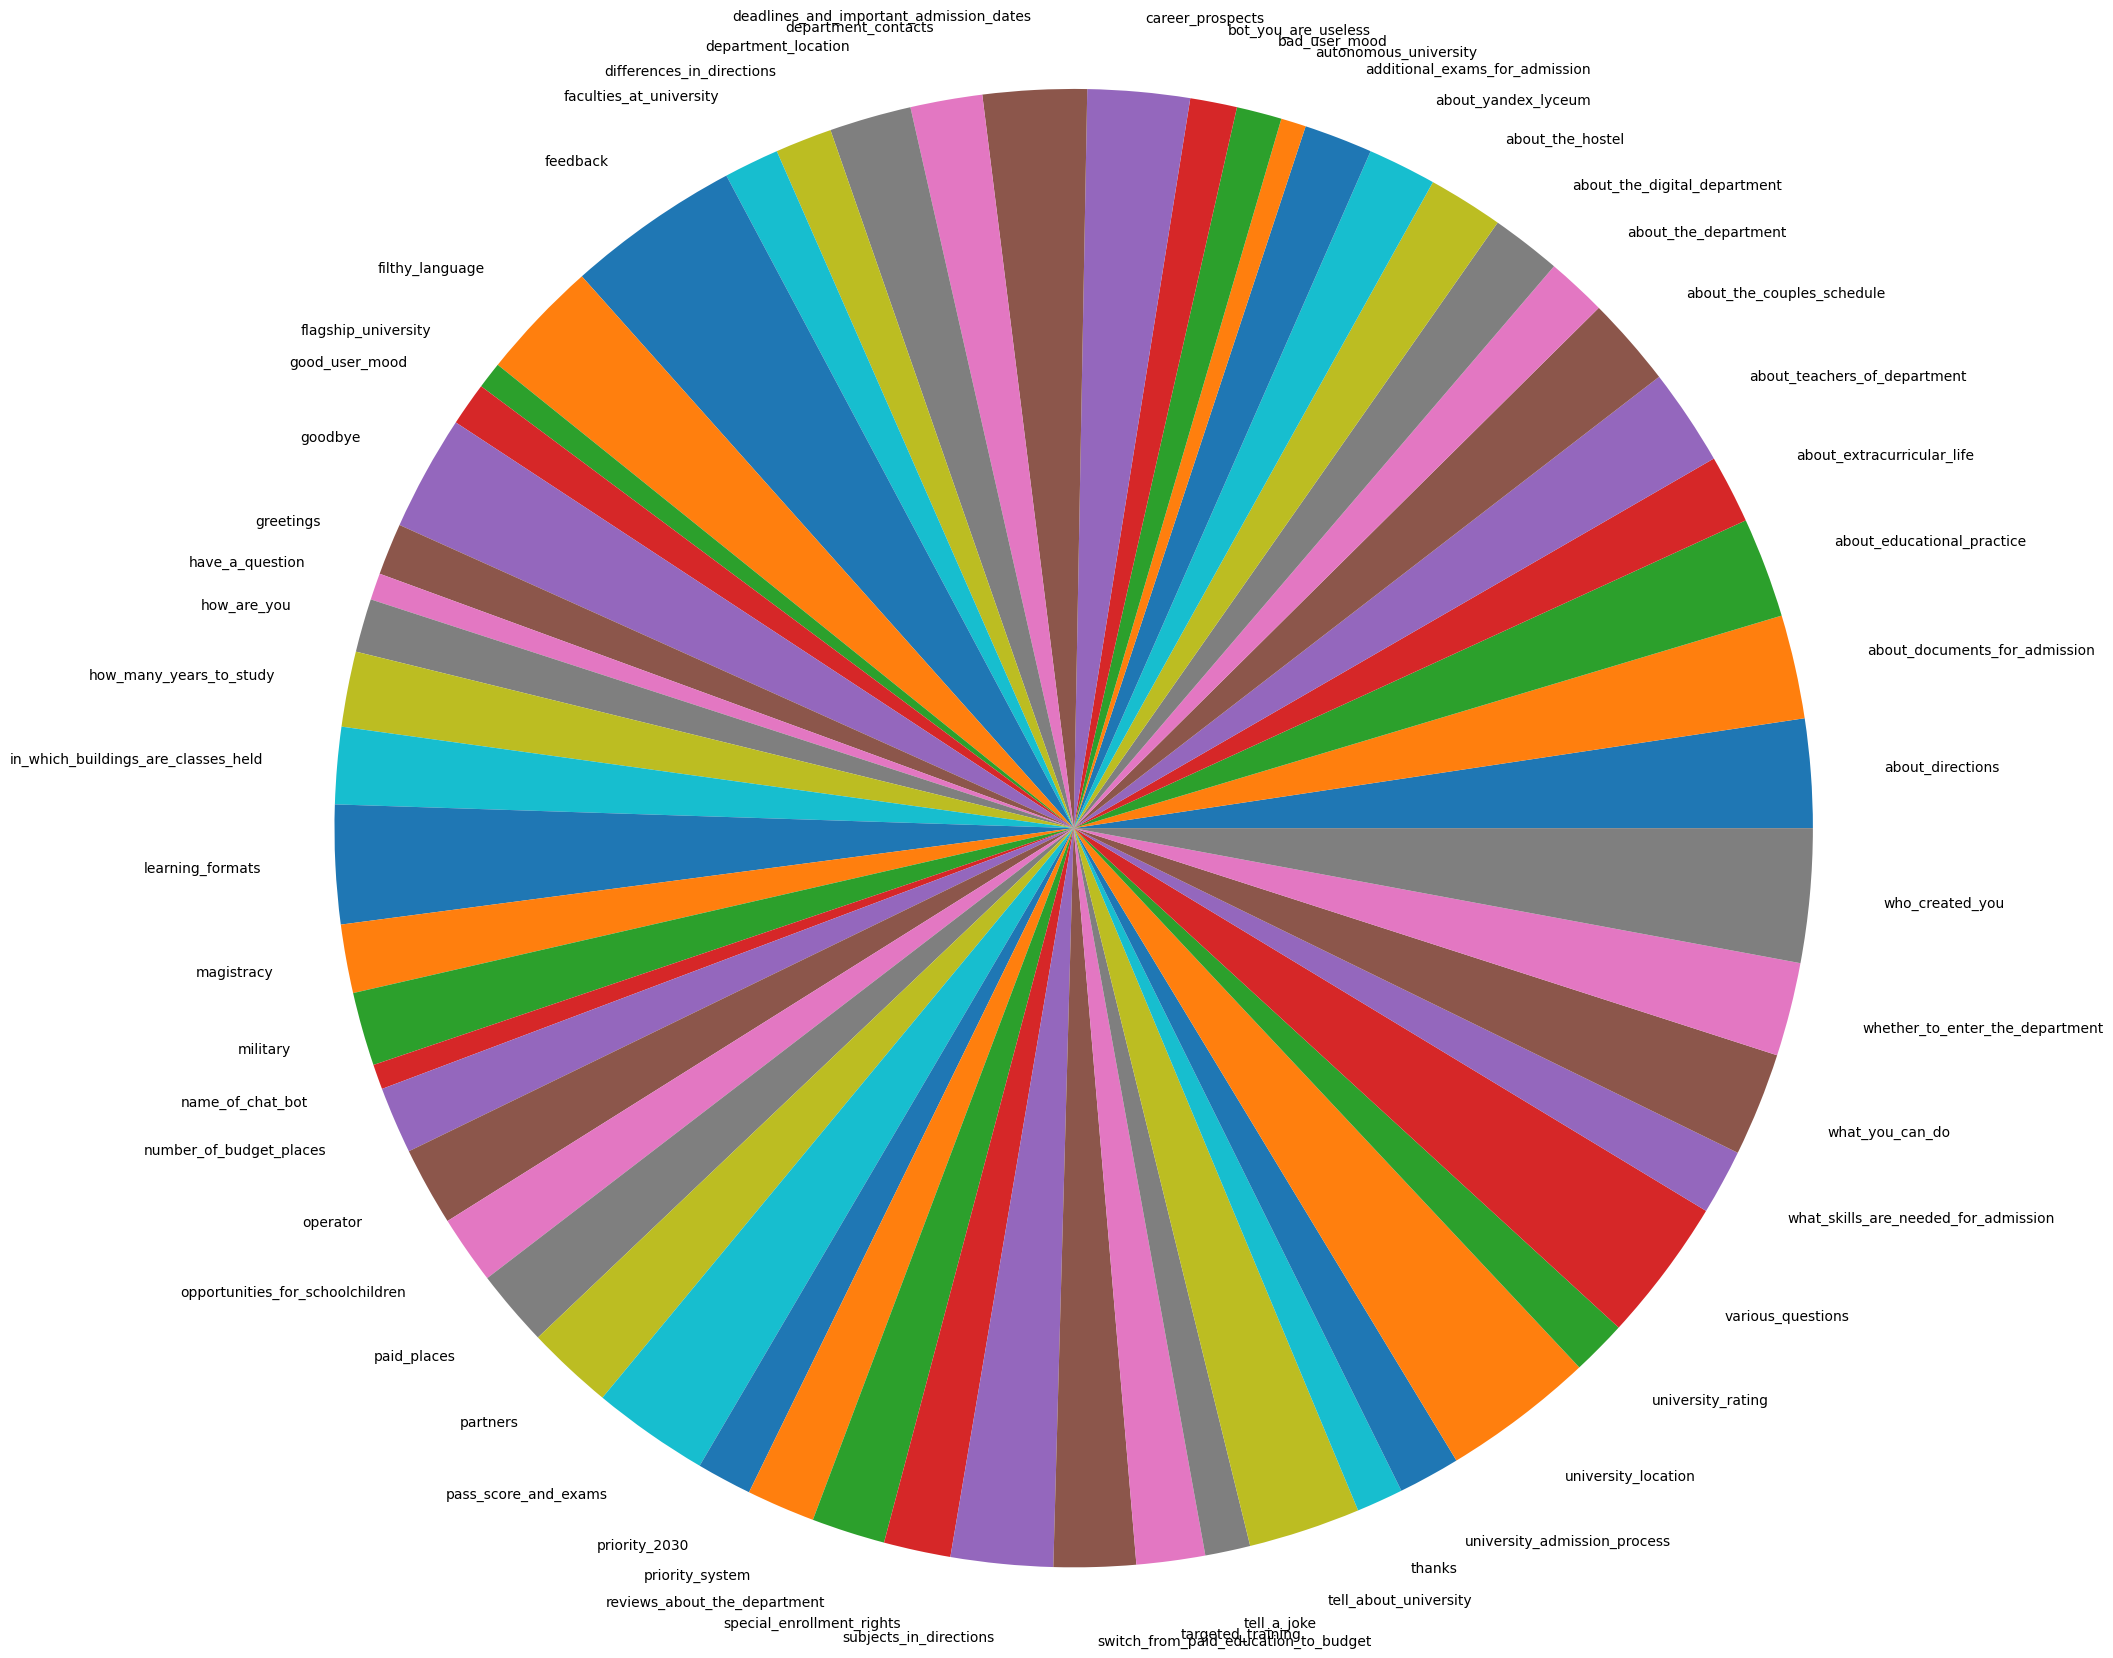

In [24]:
import matplotlib.pyplot as plt
import numpy as np

class_counts = np.unique(train_y_classes, return_counts=True)

plt.pie(class_counts[1], labels=class_counts[0], radius=5)
plt.show()

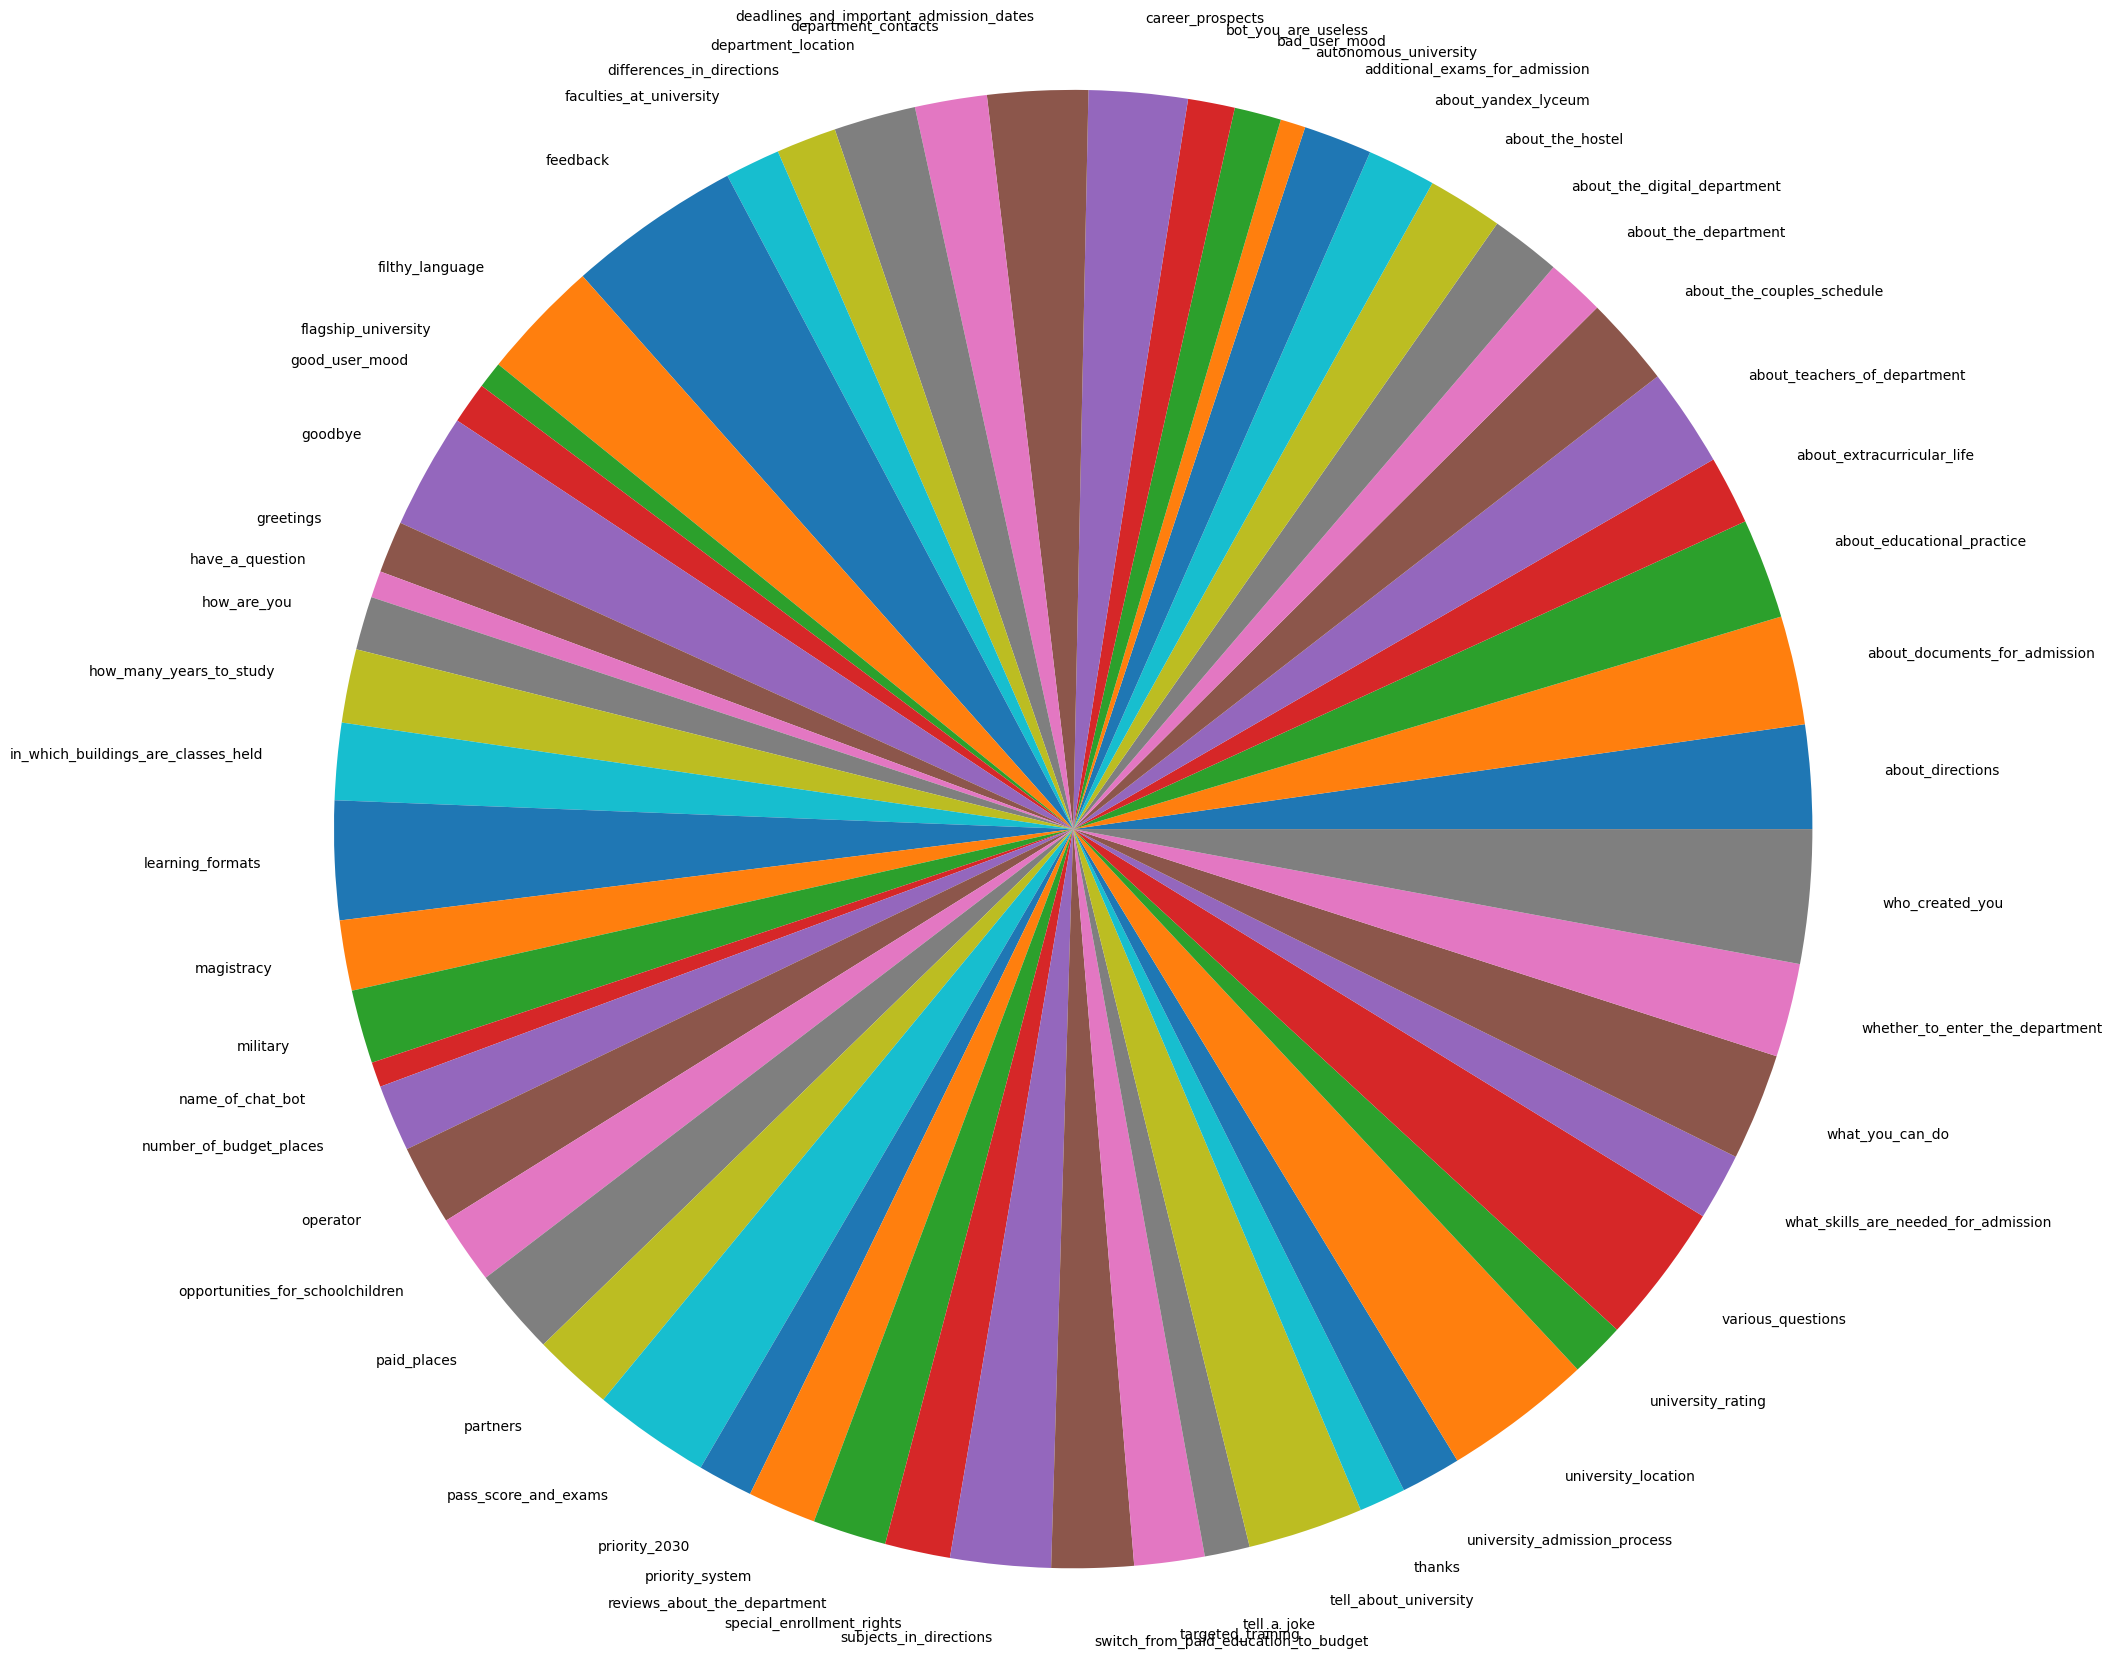

In [25]:
class_counts = np.unique(train_y_pred_classes, return_counts=True)

plt.pie(class_counts[1], labels=class_counts[0], radius=5)
plt.show()

In [26]:
print(classification_report(train_y_classes, train_y_pred_classes, zero_division=0))

precision    recall  f1-score   support

                       about_directions       0.98      0.94      0.96        65
          about_documents_for_admission       0.94      0.98      0.96        62
             about_educational_practice       1.00      1.00      1.00        60
             about_extracurricular_life       1.00      1.00      1.00        41
           about_teachers_of_department       0.98      1.00      0.99        58
             about_the_couples_schedule       1.00      1.00      1.00        54
                   about_the_department       1.00      0.97      0.99        36
           about_the_digital_department       1.00      1.00      1.00        42
                       about_the_hostel       1.00      1.00      1.00        45
                    about_yandex_lyceum       1.00      1.00      1.00        41
         additional_exams_for_admission       1.00      1.00      1.00        41
                  autonomous_university       1.00      1.00      1.00        15
                          bad_user_mood       0.96      1.00      0.98        27
                    bot_you_are_useless       1.00      1.00      1.00        28
                       career_prospects       0.98      0.95      0.97        61
deadlines_and_important_admission_dates       0.98      0.95      0.97        62
                    department_contacts       1.00      1.00      1.00        43
                    department_location       1.00      1.00      1.00        49
              differences_in_directions       0.94      1.00      0.97        34
                faculties_at_university       1.00      1.00      1.00        33
                               feedback       1.00      1.00      1.00       104
                        filthy_language       1.00      1.00      1.00        72
                    flagship_university       1.00      1.00      1.00        16
                         good_user_mood       1.00      0.96      0.98        26
                                goodbye       1.00      1.00      1.00        69
                              greetings       1.00      1.00      1.00        31
                        have_a_question       1.00      1.00      1.00        16
                            how_are_you       0.91      0.91      0.91        32
                how_many_years_to_study       1.00      0.98      0.99        45
    in_which_buildings_are_classes_held       1.00      1.00      1.00        46
                       learning_formats       1.00      1.00      1.00        71
                             magistracy       0.98      1.00      0.99        41
                               military       1.00      1.00      1.00        44
                       name_of_chat_bot       1.00      1.00      1.00        15
                number_of_budget_places       1.00      1.00      1.00        40
                               operator       0.98      1.00      0.99        47
       opportunities_for_schoolchildren       1.00      1.00      1.00        41
                            paid_places       0.87      0.98      0.92        46
                               partners       0.92      0.85      0.88        52
                   pass_score_and_exams       1.00      1.00      1.00        70
                          priority_2030       1.00      1.00      1.00        33
                        priority_system       1.00      1.00      1.00        41
           reviews_about_the_department       1.00      1.00      1.00        44
              special_enrollment_rights       1.00      0.97      0.99        40
                 subjects_in_directions       1.00      0.98      0.99        61
   switch_from_paid_education_to_budget       1.00      1.00      1.00        49
                      targeted_training       0.98      1.00      0.99        41
                            tell_a_joke       1.00      1.00      1.00        27
                  tell_about_university       0.97      1.00      0.99 

In [27]:
%%time

def predict_intent(sentence: str, model, intents, threshold=0.75) -> list[dict]:
    """
    User's text predicts his intention.
    :param sentence: user's text.
    :param model: chat bot model.
    :return: list with a dictionary, which indicates the most probable intention and its probability.
    """
    vector = to_predict.transform(sentence)
    intention_probability_vector = model.predict(vector, verbose=0)[0]
    results = [(i, r) for i, r in enumerate(intention_probability_vector) if r > threshold]
    if len(results) == 0:
        return [{"intent": "NONE", "probability": 1}]
    results.sort(key=lambda x: x[1], reverse=True)

    results_list = []
    for r in results:
        results_list.append({"intent": intents[r[0]], "probability": r[1]})
    return results_list


sentence = "Спасибо за всё, я спатки."
predict_intent(sentence, model, unique_sorted_intents)

CPU times: total: 188 ms
Wall time: 335 ms


[{'intent': 'thanks', 'probability': 0.9545641}]

In [28]:
from src.packages.path_storage import PathStorage
from loguru import logger

log_filename = (
        str(PathStorage.get_path_to_current_dir().relative_to(PathStorage.get_path_to_project_root())).replace("\\",
                                                                                                               "_") + ".log")
path_to_log = PathStorage.get_path_to_logs() / log_filename
logger.add(path_to_log,
           level="DEBUG",
           rotation="100 MB",
           compression="zip",
           enqueue=True
           )

2

## Метрики быстродействия

In [29]:
from tqdm import tqdm
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn' (появляется предупреждение при записи через .loc)

tqdm.pandas()

start = time.time()

batch_size = len(data)
batch_start = 0

for i in range(batch_start * batch_size, len(data), batch_size):
    try:
        data_batch = data.iloc[i:i + batch_size]
        pred_intents = data_batch['pattern'].progress_apply(
            lambda x: predict_intent(x, model, unique_sorted_intents, 0))
        data_batch.loc[:, 'pred_intents'] = pred_intents
        data_batch.loc[:, 'pred_intent'] = pred_intents.apply(lambda x: x[0].get("intent"))
        data_batch.to_csv(PathStorage.get_path_to_data() / "perceptron" / f"data_pred_batch_{i}.csv",
                                         encoding='utf-8',
                                         index=False)
        data.loc[i:i + batch_size - 1, 'pred_intents'] = data_batch['pred_intents']
        data.loc[i:i + batch_size - 1, 'pred_intent'] = data_batch['pred_intent']
        logger.info(f"Батч от {i} до {i + batch_size} успешно обработан")
    except Exception as exception:
        logger.critical(f"Батч от {i} до {i + batch_size}, исключение - {exception}")

total_pred_time = time.time() - start
print(total_pred_time)

100%|██████████| 2737/2737 [18:46<00:00,  2.43it/s]
2023-05-31 22:26:25.093 | INFO     | __main__:<module>:25 - Батч от 0 до 2737 успешно обработан


1126.4066970348358

In [30]:
data

pattern      true_intent  \
0                                                Привет        greetings   
1                                           Добрый день        greetings   
2                                          Здравствуйте        greetings   
3                                          Добрый вечер        greetings   
4                                           Доброе утро        greetings   
...                                                 ...              ...   
2732  Какие технические проблемы решались командой р...  who_created_you   
2733  Какие стратегии разработчики применяют для неп...  who_created_you   
2734  Какие практики и методологии разработки примен...  who_created_you   
2735  Какие идеи и предложения пользователей внедрен...  who_created_you   
2736  Какие преимущества имеет команда разработчиков...  who_created_you   

                                           pred_intents      pred_intent  
0     [{'intent': 'greetings', 'probability': 0.9983...        greetings  
1     [{'intent': 'greetings', 'probability': 0.9897...        greetings  
2     [{'intent': 'greetings', 'probability': 0.9915...        greetings  
3     [{'intent': 'greetings', 'probability': 0.9997...        greetings  
4     [{'intent': 'greetings', 'probability': 0.9990...        greetings  
...                                                 ...              ...  
2732  [{'intent': 'who_created_you', 'probability': ...  who_created_you  
2733  [{'intent': 'who_created_you', 'probability': ...  who_created_you  
2734  [{'intent': 'who_created_you', 'probability': ...  who_created_you  
2735  [{'intent': 'who_created_you', 'probability': ...  who_created_you  
2736  [{'intent': 'who_created_you', 'probability': ...  who_created_you  

[2737 rows x 4 columns]

In [31]:
# for i in range(0, len(data), batch_size):
#     data_batch = DataLoader.load_pandas_dataframe(PathStorage.get_path_to_data() / "perceptron" / f"data_pred_batch_{i}.csv")
#     data.loc[i:i+batch_size-1, "pred_intents"] = data_batch["pred_intents"].values
#     data.loc[i:i+batch_size-1, "pred_intent"] = data_batch["pred_intent"].values
#
# data

In [32]:
wrong_pred = data[data["pred_intent"] != data["true_intent"]]
wrong_pred

pattern  \
131                             Как ты себя чувствуешь?   
139                                         how are you   
143                             Как проходит твой день?   
149                                     Как настроение?   
323                        Я очень хорошо себя чувствую   
359            Что ты обычно делаешь в свободное время?   
371             Какие твои планы на ближайший выходной?   
458                                           Где ОмГТУ   
459                                         Где политех   
846                                  Расскажи о кафедре   
1090                    Какие направления есть на ПМиФИ   
1093                                       Что такое МО   
1101                                    Расскажи про МО   
1150  Какие методы исследования и анализа используют...   
1397                   Есть ли сроки подачи документов?   
1438                       Когда можно подать документы   
1453      Какие сроки подачи документов на поступление?   
1484     Когда нужно подавать документы на поступление?   
1579                        Что после подачи документов   
1624                         Что такое целевое обучение   
1796  Есть ли возможность перевестись на платное отд...   
1976                                     Что преподают?   
2080                Сколько лет учиться на магистратуру   
2385                       Кем будет работать выпускник   
2391           Можно ли поступить на платное отделение?   
2392         Каковы условия обучения на платной основе?   
2393            Как узнать стоимость платного обучения?   
2395  Какие преимущества и недостатки у платного обу...   
2396          Что входит в стоимость платного обучения?   
2397     Могу ли я получить скидку на платное обучение?   
2398  Какие формы оплаты предусмотрены для платного ...   
2434                                кем я буду работать   
2439                               Кем я буду работать?   
2465   В каких компаниях выпускники могут найти работу?   
2496                          Какие навыки у тебя есть?   
2497                              Чем ты можешь помочь?   
2512                                   Как у тебя дела?   
2513                                  Как ты поживаешь?   

                                  true_intent  \
131                               how_are_you   
139                               how_are_you   
143                               how_are_you   
149                               how_are_you   
323                            good_user_mood   
359                         various_questions   
371                         various_questions   
458                       university_location   
459                       university_location   
846                      about_the_department   
1090                         about_directions   
1093                         about_directions   
1101                         about_directions   
1150                         about_directions   
1397            about_documents_for_admission   
1438  deadlines_and_important_admission_dates   
1453  deadlines_and_important_admission_dates   
1484  deadlines_and_important_admission_dates   
1579             university_admission_process   
1624                special_enrollment_rights   
1796                              paid_places   
1976                   subjects_in_directions   
2080                  how_many_years_to_study   
2385                                 partners   
2391                                 partners   
2392                                 partners   
2393                                 partners   
2395                                 partners   
2396                                 partners   
2397                                 partners   
2398                                 partners   
2434                         career_prospects   
2439                         career_prospects   
2465                         career_prospects   
2496                          w

In [33]:
num_of_intents = data["true_intent"].nunique()
num_of_phrases = len(data)
# total_pred_time = average_execution_time_per_batch * 50
average_pred_time = round(total_pred_time / num_of_phrases, 5)

print("Общее время предсказания:", total_pred_time)
print("Количество намерений:", num_of_intents)
print("Общее количество предсказанных фраз:", num_of_phrases)
print(make_text_green_bold(f"Среднее время предсказания: {average_pred_time}"))

Общее время предсказания: 1126.4066970348358

Количество намерений: 58

Общее количество предсказанных фраз: 2737

Среднее время предсказания: 0.41155

## Метрики качества

In [34]:
print(classification_report(data["true_intent"], data["pred_intent"], zero_division=0))

precision    recall  f1-score   support

                       about_directions       0.98      0.94      0.96        65
          about_documents_for_admission       0.94      0.98      0.96        62
             about_educational_practice       1.00      1.00      1.00        60
             about_extracurricular_life       1.00      1.00      1.00        41
           about_teachers_of_department       0.98      1.00      0.99        58
             about_the_couples_schedule       1.00      1.00      1.00        54
                   about_the_department       1.00      0.97      0.99        36
           about_the_digital_department       1.00      1.00      1.00        42
                       about_the_hostel       1.00      1.00      1.00        45
                    about_yandex_lyceum       1.00      1.00      1.00        41
         additional_exams_for_admission       1.00      1.00      1.00        41
                  autonomous_university       1.00      1.00      1.00        15
                          bad_user_mood       0.96      1.00      0.98        27
                    bot_you_are_useless       1.00      1.00      1.00        28
                       career_prospects       0.98      0.95      0.97        61
deadlines_and_important_admission_dates       0.98      0.95      0.97        62
                    department_contacts       1.00      1.00      1.00        43
                    department_location       1.00      1.00      1.00        49
              differences_in_directions       0.94      1.00      0.97        34
                faculties_at_university       1.00      1.00      1.00        33
                               feedback       1.00      1.00      1.00       104
                        filthy_language       1.00      1.00      1.00        72
                    flagship_university       1.00      1.00      1.00        16
                         good_user_mood       1.00      0.96      0.98        26
                                goodbye       1.00      1.00      1.00        69
                              greetings       0.97      1.00      0.98        31
                        have_a_question       1.00      1.00      1.00        16
                            how_are_you       0.91      0.88      0.89        33
                how_many_years_to_study       1.00      0.98      0.99        45
    in_which_buildings_are_classes_held       1.00      1.00      1.00        46
                       learning_formats       1.00      1.00      1.00        71
                             magistracy       0.98      1.00      0.99        41
                               military       1.00      1.00      1.00        44
                       name_of_chat_bot       1.00      1.00      1.00        15
                number_of_budget_places       1.00      1.00      1.00        40
                               operator       0.98      1.00      0.99        47
       opportunities_for_schoolchildren       1.00      1.00      1.00        41
                            paid_places       0.87      0.98      0.92        46
                               partners       0.92      0.85      0.88        52
                   pass_score_and_exams       1.00      1.00      1.00        70
                          priority_2030       1.00      1.00      1.00        33
                        priority_system       1.00      1.00      1.00        41
           reviews_about_the_department       1.00      1.00      1.00        44
              special_enrollment_rights       1.00      0.97      0.99        40
                 subjects_in_directions       1.00      0.98      0.99        61
   switch_from_paid_education_to_budget       1.00      1.00      1.00        49
                      targeted_training       0.98      1.00      0.99        41
                            tell_a_joke       1.00      1.00      1.00        27
                  tell_about_university       0.97      1.00      0.99 

In [35]:
report = classification_report(data["true_intent"], data["pred_intent"], zero_division=0, output_dict=True)

report.keys()
macro_avg_f1 = report.get("macro avg").get("f1-score")
micro_avg_f1 = report.get("accuracy")
weighted_avg_f1 = report.get("weighted avg").get("f1-score")

print(make_text_green_bold(f"Macro avg f1: {macro_avg_f1}"))
print("Micro avg f1:", micro_avg_f1)
print("Weighted avg f1:", weighted_avg_f1)

Macro avg f1: 0.98673903548434

Micro avg f1: 0.9861161856046766

Weighted avg f1: 0.986112482547654